In [1]:
import config
from RiotAPI import *
from RiotRequest import RiotRequest
import requests

In [11]:
# timestamp handling functions
from datetime import timedelta
from datetime import datetime
import pytz

def convert_timedelta(milisecs):
    '''
    convert milisecond timestamp into python timedelta object
    for sake of compatiability, convert into only minutes and seconds (without hours)
    '''
    minDelta = timestamp // 60000 # 60000 miliseconds == 1 minute
    secDelta = (timestamp % 60000) // 1000 # 1000 miliseconds == 1 second
    return timedelta(minutes = minDelta, seconds = secDelta)

def convert_timestamp(timestamp):
    '''convert unix timestamp(long) into python datetime object with Korean Timezone'''
   
    # dealing with miliseconds part
    timestamp = timestamp/1000
    # convert from utc into datetime timestamp
    dt = datetime.utcfromtimestamp(timestamp).replace(tzinfo=pytz.utc)
    
    # convert into Korean timezone
    tz = pytz.timezone("Asia/Seoul")
    dt_kr = dt.astimezone(tz)
    
    return dt_kr

In [2]:
api_key = config.api_key
game_id = 3309773060
summoner_name = "야너어어어엌"
account_id = get_account_id(summoner_name)

Successful


## Match Time History

In [3]:
history = [match['gameId'] for match in get_match_history(account_id)]

Successful
Successful
Successful
Successful
Successful
Successful


In [13]:
len(history)

568

In [14]:
# get game detail에서 gameCreation이랑 gameDuration만 불러오기

# 이러면 get_game_detail을 두 번 호출함ㅜㅜ --> 너무 오래걸림
# history = [[matchId, get_game_detail(matchId)['gameCreation'], get_game_detail(matchId)['gameDuration']] for matchId in history]

def get_timeinfo(matchId):
    detail = get_game_detail(matchId)
    return [matchId, detail['gameCreation'], detail['gameDuration']]

# temporarily recent 300 games
time_history = [get_timeinfo(matchId) for matchId in history[:300]]


Successful
Successful
Successful
Successful
Successful
Successful
Successful
Successful
Successful
Successful
Successful
Successful
Successful
Successful
Successful
Successful
Successful
Successful
Successful
Successful
Successful
Successful
Successful
Successful
Successful
Successful
Successful
Successful
Successful
Successful
Successful
Successful
Successful
Successful
Successful
Successful
Successful
Successful
Successful
Successful
Successful
Successful
Successful
Successful
Successful
Successful
Successful
Successful
Successful
Successful
Successful
Successful
Successful
Successful
Successful
Successful
Successful
Successful
Successful
Successful
Successful
Successful
Successful
Successful
Successful
Successful
Successful
Successful
Successful
Successful
Successful
Successful
Successful
Successful
Successful
Successful
Successful
Successful
Successful
Successful
Successful
Successful
Successful
Successful
Successful
Successful
Successful
Successful
Successful
Successful
Successful

In [19]:
import pandas as pd
match_df = pd.DataFrame(time_history, columns=['matchId', 'creation', 'duration'])

In [21]:
# add unix timestamp of the time game ended
match_df['ended'] = match_df['creation'] + match_df['duration']*1000

# add datetime columns for creation and ending time
match_df['creation_dt'] = match_df['creation'].apply(convert_timestamp)
match_df['ended_dt'] = match_df['ended'].apply(convert_timestamp)

match_df.head()

,matchId,creation,duration,ended,creation_dt,ended_dt
0,3663346965,1557981210348,1285,1557982495348,2019-05-16 13:33:30.348000+09:00,2019-05-16 13:54:55.348000+09:00
1,3663315079,1557979516493,1501,1557981017493,2019-05-16 13:05:16.493000+09:00,2019-05-16 13:30:17.493000+09:00
2,3662344066,1557912999893,1220,1557914219893,2019-05-15 18:36:39.893000+09:00,2019-05-15 18:56:59.893000+09:00
3,3659959097,1557747014172,1783,1557748797172,2019-05-13 20:30:14.172000+09:00,2019-05-13 20:59:57.172000+09:00
4,3658808527,1557660795816,1698,1557662493816,2019-05-12 20:33:15.816000+09:00,2019-05-12 21:01:33.816000+09:00


## Grouping Matches

In [34]:
df = match_df.sort_values(by=['creation'])
for index, row in df.iterrows():
    print(index, row)

299 matchId                              3254986417
creation                          1530250814307
duration                                   1732
ended                             1530252546307
creation_dt    2018-06-29 14:40:14.307000+09:00
ended_dt       2018-06-29 15:09:06.307000+09:00
Name: 299, dtype: object
298 matchId                              3255011184
creation                          1530252871231
duration                                   1825
ended                             1530254696231
creation_dt    2018-06-29 15:14:31.231000+09:00
ended_dt       2018-06-29 15:44:56.231000+09:00
Name: 298, dtype: object
297 matchId                              3255016308
creation                          1530255080073
duration                                   1923
ended                             1530257003073
creation_dt    2018-06-29 15:51:20.073000+09:00
ended_dt       2018-06-29 16:23:23.073000+09:00
Name: 297, dtype: object
296 matchId                              32574657

Name: 104, dtype: object
103 matchId                              3318330120
creation                          1535035935631
duration                                   1718
ended                             1535037653631
creation_dt    2018-08-23 23:52:15.631000+09:00
ended_dt       2018-08-24 00:20:53.631000+09:00
Name: 103, dtype: object
102 matchId                              3318700651
creation                          1535088269595
duration                                   2130
ended                             1535090399595
creation_dt    2018-08-24 14:24:29.595000+09:00
ended_dt       2018-08-24 14:59:59.595000+09:00
Name: 102, dtype: object
101 matchId                              3318707577
creation                          1535090908797
duration                                   2426
ended                             1535093334797
creation_dt    2018-08-24 15:08:28.797000+09:00
ended_dt       2018-08-24 15:48:54.797000+09:00
Name: 101, dtype: object
100 matchId             

In [61]:
import numpy as np
diff = np.array(match_df['creation'][:-1]) - np.array(match_df['ended'][1:])
len(diff)

299

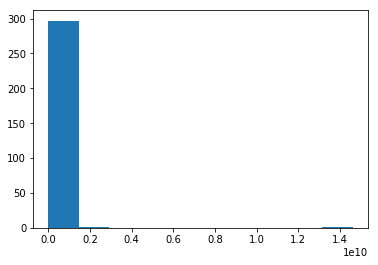

In [47]:
import matplotlib
import matplotlib.pyplot as plt
plt = plt.hist(diff)

In [66]:
full_diff = np.append([float('Inf')], diff)
full_diff
match_df['diff'] = full_diff
match_df.head()

,matchId,creation,duration,ended,creation_dt,ended_dt,diff
0,3663346965,1557981210348,1285,1557982495348,2019-05-16 13:33:30.348000+09:00,2019-05-16 13:54:55.348000+09:00,inf
1,3663315079,1557979516493,1501,1557981017493,2019-05-16 13:05:16.493000+09:00,2019-05-16 13:30:17.493000+09:00,1.928550e+05
2,3662344066,1557912999893,1220,1557914219893,2019-05-15 18:36:39.893000+09:00,2019-05-15 18:56:59.893000+09:00,6.529660e+07
3,3659959097,1557747014172,1783,1557748797172,2019-05-13 20:30:14.172000+09:00,2019-05-13 20:59:57.172000+09:00,1.642027e+08
4,3658808527,1557660795816,1698,1557662493816,2019-05-12 20:33:15.816000+09:00,2019-05-12 21:01:33.816000+09:00,8.452036e+07


In [ ]:
# seq_df = pd.Dataframe(columns = ['start_dt', 'end_dt', 'matchNum', 'matchIds'])
seqs = []

for index, row in match_df.iterrows():
    # list of one time game sequence
    
    # diff with previous game smaller than 10 minutes
    while row['diff'] < 600000:
        seq.append(row['matchId'])
        
        